**Srayan Gangopadhyay**
*11th June 2020*

# Bouncing a particle off a 'blob' of magnetic field

To start with, let's just put some real-world values into the code and adjust the step size and endpoint to make sure everything still works with these large numbers.

In [ ]:
"""
Bouncing particles
Srayan Gangopadhyay
2020-06-11
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML, display  # show anim. in ntbk
from tabulate import tabulate  # pretty text output
from datetime import datetime  # timestamp for output files
from tqdm import tqdm  # progress bar

# PARAMETERS
r0 = [1e7,1e7, 0]  # initial position
v0 = [1e7, 1e7, 0]  # initial velocity
q, m = 1.6e-19, 1.67e-27  # charge, mass
h = 0.01  # step size
end = 20  # t-value to stop integration
size = [1e8,1e8,np.inf]  # simulation dimensions
frames = 100  # for animation TODO: can we set this automatically?
anim = False  # switch animation on/off
export = False  # switch data dump on/off

def B_field(r):
    """Returns the components of the magnetic
    field, given a 3D position vector."""
    return [1e-9, 1e-16, 2e-8]

def E_field(r):
    """Returns the components of the electric
    field, given a 3D position vector."""
    return [0,0,0]

def lorentz(r, vel, E, B):
    """The Lorentz force equation. Returns
    acceleration of particle given its
    position, velocity, E field
    function, and B field function."""
    return (q/m)*(E(r) + np.cross(vel, B(r)))

# RUNGE-KUTTA INTEGRATOR
def rk4(func, init1, init2, h, end):
    """Takes the RHS of a 2nd-order ODE with initial conditions,
    step size and end point, and integrates using the 4th-order
    Runge-Kutta algorithm. Returns solution in an array.

    r'' = f(t, r, v) where v = r'

    func: the function to be integrated
    init1: value of r at t=0
    init2: value of v at t=0
    h: step size
    end: t-value to stop integrating
    """
    steps = int(end/h)  # number of steps
    r = np.zeros((3, steps))  # empty matrix for solution
    v = np.zeros((3, steps))
    r[:,0] = init1  # inserting initial value
    v[:,0] = init2

    for i in tqdm(range(0, steps-1), desc='Integrating'):
        k1r = h * v[:,i]
        k1v = h * func(r[:,i], v[:,i], E_field, B_field)
        k2r = h * (v[:,i] + 0.5*k1v)
        k2v = h * func(r[:,i], v[:,i] + 0.5*k1v, E_field, B_field)
        k3r = h * (v[:,i] + 0.5*k2v)
        k3v = h * func(r[:,i], v[:,i] + 0.5*k2v, E_field, B_field)
        k4r = h * (v[:,i] + k3v)
        k4v = h * func(r[:,i], v[:,i] + k3v, E_field, B_field)
        new_r = r[:,i] + (k1r + 2*k2r + 2*k3r + k4r) / 6
        new_v = v[:,i] + (k1v + 2*k2v + 2*k3v + k4v) / 6
        
        if (new_r[0] < size[0]*-0.5):  # stop particle leaving box
            new_r[0] += size[0]        # TODO: is there a neater way?
        if (new_r[0] >= size[0]*0.5):
            new_r[0] -= size[0]
        if (new_r[1] < size[1]*-0.5):
            new_r[1] += size[1]
        if (new_r[1] >= size[1]*0.5):
            new_r[1] -= size[1]
        if (new_r[2] < size[2]*-0.5):
            new_r[2] += size[2]
        if (new_r[2] >= size[2]*0.5):
            new_r[2] -= size[2]
            
        r[:,i+1] = new_r
        v[:,i+1] = new_v
    return r, v

r, v = rk4(lorentz, r0, v0, h, end)  # call the integrator

# calculate moduli of vectors
distances = np.linalg.norm(r, axis=0)
speeds = np.linalg.norm(v, axis=0)

# EXPORTING DATA TO .CSV FILE
if export:  # TODO: can we move this into a function?
    filename = datetime.now().strftime("%Y%m%d-%H%M%S") + "_data.csv"
    with open(filename, 'a') as f:
        f.write("r-vectors\n")
        np.savetxt(f, r, delimiter=",")
        f.write("\nv-vectors\n")
        np.savetxt(f, v, delimiter=",")
        f.write("\ndistances\n")
        np.savetxt(f, distances[None], delimiter=",")
        f.write("\nspeeds\n")
        np.savetxt(f, speeds[None], delimiter=",")
    print("\nExported full data to ",filename)

fig = plt.figure()  # generate a figure
ax = Axes3D(fig)  # set up 3d axes

def animate(i):
    j = 100*i  # to skip frames and change animation speed
    ax.plot3D(r[0, :j], r[1, :j], r[2, :j], '.', color='magenta')
    pbar.update(1)  # increment progress bar
    
ax.set_xlabel('x')  # TODO: can we move this into a function?
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, -113)  # change viewing angle
ax.set_xlim3d(np.amin(r[0]), np.amax(r[0]))  # auto-scale axes
ax.set_ylim3d(np.amin(r[1]), np.amax(r[1]))
ax.set_zlim3d(np.amin(r[2]), np.amax(r[2]))

if not anim:
    ax.plot3D(r[0], r[1], r[2], '.', color='magenta')
    plt.show
else:
    animation = animation.FuncAnimation(fig, animate,  # call the animator
                                        frames=frames, interval=50, blit=False, repeat=False)
    pbar = tqdm(total=frames+1, desc='Animating')  # start progress bar
    display(HTML(animation.to_html5_video()))
    pbar.close()  # close progress bar

print("\n",tabulate([['Max. distance', np.amax(distances)], 
                     ['Avg. distance', np.mean(distances)], 
                     ['Max. speed', np.amax(speeds)], 
                     ['Avg. speed', np.mean(speeds)]], 
                    headers=['Parameter', 'Value']))

That looks correct, and it's not complaining about infinite values.

Now let's linearly increase the field in the z-direction.

In [ ]:
# PARAMETERS
r0 = [1e7,1e7, 0]  # initial position
v0 = [1e7, 1e7, 0]  # initial velocity
q, m = 1.6e-19, 1.67e-27  # charge, mass
h = 0.01  # step size
end = 100  # t-value to stop integration
size = [1e8,1e8,1e10]  # simulation dimensions
frames = 100  # for animation TODO: can we set this automatically?
anim = False  # switch animation on/off
export = False  # switch data dump on/off

def B_field(r):
    """Returns the components of the magnetic
    field, given a 3D position vector."""
    if 2e6 <= r[2]:
        return [1e-9, 1e-16, 1e-14*r[2]]
    else:
        return [1e-9, 1e-16, 2e-8]

r, v = rk4(lorentz, r0, v0, h, end)  # call the integrator

fig = plt.figure()  # generate a figure
ax = Axes3D(fig)  # set up 3d axes

def animate(i):
    j = 100*i  # to skip frames and change animation speed
    ax.plot3D(r[0, :j], r[1, :j], r[2, :j], '.', color='magenta')
    pbar.update(1)  # increment progress bar
    
ax.set_xlabel('x')  # TODO: can we move this into a function?
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, -113)  # change viewing angle
ax.set_xlim3d(np.amin(r[0]), np.amax(r[0]))  # auto-scale axes
ax.set_ylim3d(np.amin(r[1]), np.amax(r[1]))
ax.set_zlim3d(np.amin(r[2]), np.amax(r[2]))

if not anim:
    ax.plot3D(r[0], r[1], r[2], '.', color='magenta')
    plt.show
else:
    animation = animation.FuncAnimation(fig, animate,  # call the animator
                                        frames=frames, interval=50, blit=False, repeat=False)
    pbar = tqdm(total=frames+1, desc='Animating')  # start progress bar
    display(HTML(animation.to_html5_video()))
    pbar.close()  # close progress bar

It's spiralling inwards - that's a good sign. Hopefully, if we just keep going, it'll eventually turn around...  
Setting `end` to 300.

In [ ]:
end = 300  # t-value to stop integration

r, v = rk4(lorentz, r0, v0, h, end)  # call the integrator

# calculate moduli of vectors
distances = np.linalg.norm(r, axis=0)
speeds = np.linalg.norm(v, axis=0)

fig = plt.figure()  # generate a figure
ax = Axes3D(fig)  # set up 3d axes

def animate(i):
    j = 100*i  # to skip frames and change animation speed
    ax.plot3D(r[0, :j], r[1, :j], r[2, :j], '.', color='magenta')
    pbar.update(1)  # increment progress bar
    
ax.set_xlabel('x')  # TODO: can we move this into a function?
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, -113)  # change viewing angle
ax.set_xlim3d(np.amin(r[0]), np.amax(r[0]))  # auto-scale axes
ax.set_ylim3d(np.amin(r[1]), np.amax(r[1]))
ax.set_zlim3d(np.amin(r[2]), np.amax(r[2]))

if not anim:
    ax.plot3D(r[0], r[1], r[2], '.', color='magenta')
    plt.show
else:
    animation = animation.FuncAnimation(fig, animate,  # call the animator
                                        frames=frames, interval=50, blit=False, repeat=False)
    pbar = tqdm(total=frames+1, desc='Animating')  # start progress bar
    display(HTML(animation.to_html5_video()))
    pbar.close()  # close progress bar

print("\n",tabulate([['Max. distance', np.amax(distances)], 
                     ['Avg. distance', np.mean(distances)], 
                     ['Max. speed', np.amax(speeds)], 
                     ['Avg. speed', np.mean(speeds)]], 
                    headers=['Parameter', 'Value']))

_So_ close...  
Setting `end` to 400.

In [ ]:
end = 400  # t-value to stop integration

r, v = rk4(lorentz, r0, v0, h, end)  # call the integrator

# calculate moduli of vectors
distances = np.linalg.norm(r, axis=0)
speeds = np.linalg.norm(v, axis=0)

fig = plt.figure()  # generate a figure
ax = Axes3D(fig)  # set up 3d axes

def animate(i):
    j = 100*i  # to skip frames and change animation speed
    ax.plot3D(r[0, :j], r[1, :j], r[2, :j], '.', color='magenta')
    pbar.update(1)  # increment progress bar
    
ax.set_xlabel('x')  # TODO: can we move this into a function?
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, -113)  # change viewing angle
ax.set_xlim3d(np.amin(r[0]), np.amax(r[0]))  # auto-scale axes
ax.set_ylim3d(np.amin(r[1]), np.amax(r[1]))
ax.set_zlim3d(np.amin(r[2]), np.amax(r[2]))

if not anim:
    ax.plot3D(r[0], r[1], r[2], '.', color='magenta')
    plt.show
else:
    animation = animation.FuncAnimation(fig, animate,  # call the animator
                                        frames=frames, interval=50, blit=False, repeat=False)
    pbar = tqdm(total=frames+1, desc='Animating')  # start progress bar
    display(HTML(animation.to_html5_video()))
    pbar.close()  # close progress bar

print("\n",tabulate([['Max. distance', np.amax(distances)], 
                     ['Avg. distance', np.mean(distances)], 
                     ['Max. speed', np.amax(speeds)], 
                     ['Avg. speed', np.mean(speeds)]], 
                    headers=['Parameter', 'Value']))

Come on! Turn around! Please?  
Setting `end` to 450.

In [ ]:
end = 450  # t-value to stop integration

r, v = rk4(lorentz, r0, v0, h, end)  # call the integrator

# calculate moduli of vectors
distances = np.linalg.norm(r, axis=0)
speeds = np.linalg.norm(v, axis=0)

fig = plt.figure()  # generate a figure
ax = Axes3D(fig)  # set up 3d axes

def animate(i):
    j = 100*i  # to skip frames and change animation speed
    ax.plot3D(r[0, :j], r[1, :j], r[2, :j], '.', color='magenta')
    pbar.update(1)  # increment progress bar
    
ax.set_xlabel('x')  # TODO: can we move this into a function?
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, -113)  # change viewing angle
ax.set_xlim3d(np.amin(r[0]), np.amax(r[0]))  # auto-scale axes
ax.set_ylim3d(np.amin(r[1]), np.amax(r[1]))
ax.set_zlim3d(np.amin(r[2]), np.amax(r[2]))

if not anim:
    ax.plot3D(r[0], r[1], r[2], '.', color='magenta')
    plt.show()
else:
    animation = animation.FuncAnimation(fig, animate,  # call the animator
                                        frames=frames, interval=50, blit=False, repeat=False)
    pbar = tqdm(total=frames+1, desc='Animating')  # start progress bar
    display(HTML(animation.to_html5_video()))
    pbar.close()  # close progress bar

print("\n",tabulate([['Max. distance', np.amax(distances)], 
                     ['Avg. distance', np.mean(distances)], 
                     ['Max. speed', np.amax(speeds)], 
                     ['Avg. speed', np.mean(speeds)]], 
                    headers=['Parameter', 'Value']))

?!?!?!?!?!

Maybe we've hit a numerical instability and need to decrease the step size.  
Let's also try making the field _even stronger_ at the top to try and force the particle to turn around.

In [ ]:
h = 0.005  # step size
end = 500  # t-value to stop integration
size = [np.inf,np.inf,np.inf]  # simulation dimensions

r, v = rk4(lorentz, r0, v0, h, end)  # call the integrator

fig = plt.figure()  # generate a figure
ax = Axes3D(fig)  # set up 3d axes
    
ax.set_xlabel('x')  # TODO: can we move this into a function?
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, -113)  # change viewing angle
ax.set_xlim3d(np.amin(r[0]), np.amax(r[0]))  # auto-scale axes
ax.set_ylim3d(np.amin(r[1]), np.amax(r[1]))
ax.set_zlim3d(np.amin(r[2]), np.amax(r[2]))

ax.plot3D(r[0], r[1], r[2], '.', color='magenta')
plt.show()

Maybe it actually is turning around and we just can't see it. We probably need to turn on the animation to see what's going on... but that takes forever!

For the rest of this notebook, let's use our refactored code.



 Parameter            Value
-------------  -----------
Max. distance  2.5043e+07
Avg. distance  1.79977e+07
Max. speed     1.41421e+07
Avg. speed     1.41421e+07


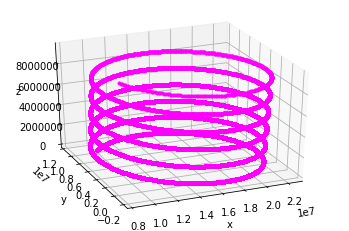

In [3]:
from y1project import *

r, v = rk4(lorentz, r0, v0, h, end)  # call the integrator
plot_or_anim(r, frames, True, *plotsetup(r))
if tableprint: printout(r, v)
if export: textout(r, v)